In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('/home/jb07/nipype_installation/')

In [4]:
import bct
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import FloatProgress
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from nilearn import plotting
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import zscore
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import sem, ttest_ind
from subprocess import call
from shutil import copyfile
import time

In [5]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 90*mm2inches
double_column = 190*mm2inches
one_half_column = 140*mm2inches

Loading the behavioural data

In [6]:
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/CALM_behavioural_data_Apr17.csv')[['ID No.', 'Age_in_months', 'Gender(1=male)', 'WIAT_Numerical_raw', 'WIAT_Numerical_Std', 'WIAT_Reading_Raw', 'WIAT_Reading_Std']]
df.columns = ['ID', 'Age', 'Gender', 'Maths', 'Maths_std', 'Reading', 'Reading_std']

Adjusting the age range

In [7]:
df = df.dropna()
df['Age'] = df['Age'].astype('float')/12
df = df[df['Age'] > 5] # removing data entry with wrong age (one case with an impossibly young age)
original_df = df.copy() # copy to plot the comparison
df = df[(df['Age'] > np.percentile(df, 5)) & (df['Age'] < np.percentile(df['Age'], 95))]

In [8]:
def get_imaging_ID(ID_string, ID_table):
    """
    Function to match behavioural an imaging IDs
    """
    
    # Reading data from the lookup table
    import pandas as pd
    data = pd.Series.from_csv(ID_table)

    # Removing brackts
    import re
    for counter in range(1,len(data)):
        entry = data[counter]
        if re.search(r"[(){}[\]]+",str(entry)):
            data[counter] = entry[1:-1]

    # Getting the matching ID
    try:
        ID = data[data.index == ID_string].values.tolist()
        return ID[0]
    except:
        return float('nan')

Removing participants with excessive movement during the dwi sequence

In [9]:
df['MRI.ID'] = [get_imaging_ID(str(int(ID)), './data/MRI_ID_match_Aug17.csv') for ID in df['ID'].values]
movement_df = pd.read_csv('/imaging/jb07/CALM/DWI/motion_estimation/Displacements_results.csv')
movement_df.columns = ['MRI.ID', 'movement', 'volumes']
subject_list = movement_df[(movement_df['movement'] < 3) & (movement_df['volumes'] == 69)]['MRI.ID']
df = df[df['MRI.ID'].isin(subject_list)]

Checking that connectome data is available for those participants

In [10]:
in_folder = '/imaging/jb07/CALM/Modularity/connectome/'
filename = lambda subject_id: in_folder + '_subject_id_' + subject_id + '/_model_CSA/_threshold_10/calc_matrix/mapflow/_calc_matrix0/' + subject_id + '_FA_matrix.txt'

In [11]:
subject_list = [subject for subject in df['MRI.ID'].values if os.path.isfile(filename(subject))]
df = df[df['MRI.ID'].isin(subject_list)]

In [16]:
print('Number of children: n=%.i' % len(df))
print('Age: mean=%.2f, std=%.3f, range=%.i-%.i' % (np.mean(df['Age']), np.std(df['Age']), np.min(df['Age']), np.max(df['Age'])))
print('Gender: male=%i' % df['Gender'].value_counts().values[0])

Number of children: n=135
Age: mean=9.33, std=1.655, range=5-13
Gender: male=88


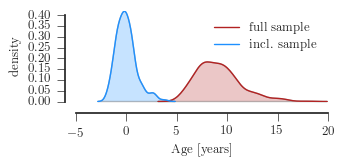

In [106]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(figsize=(90*mm2inches, 45*mm2inches), dpi=300, tight_layout=True)
sns.kdeplot(original_df['Age'], shade=True, color='firebrick')
sns.kdeplot(df['Age'], shade=True, color='dodgerblue')
sns.despine(offset=8, trim=True)
ax = plt.gca()
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(['full sample', 'incl. sample'])
plt.xlabel('Age [years]')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('./figures/Age_distributions.png', dpi=300)

In [107]:
print('Full number of participants: %i' % original_df.shape[0])
print('Restricted age range number of participants: %i' % df.shape[0])

Full number of participants: 374
Restricted age range number of participants: 144


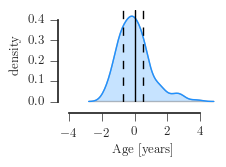

In [108]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
           'font.family': [u'serif'],
           'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(figsize=(60*mm2inches, 45*mm2inches), dpi=300, tight_layout=True)
sns.kdeplot(df['Age'], shade=True, color='dodgerblue')
plt.axvline(df['Age'].mean(), linewidth=1, color='k')
plt.axvline(np.percentile(df['Age'], 25), linewidth=1, color='k', linestyle='dashed')
plt.axvline(np.percentile(df['Age'], 75), linewidth=1, color='k', linestyle='dashed')
ax = plt.gca()
ax.set_xticks(np.linspace(-4, 4, 5))
ax.set_yticks(np.linspace(0, 0.4, 5))
sns.despine(offset=8, trim=True)
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend([' '])
plt.xlabel('Age [years]')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('./figures/Age_distribution.png', dpi=300)

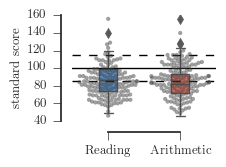

In [109]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(figsize=(60*mm2inches, 45*mm2inches), dpi=300, tight_layout=True)
plot_df = pd.melt(df[['Maths_std', 'Reading_std']])
plot_df['variable'] = pd.Categorical(plot_df['variable'].values, categories=['Reading_std', 'Maths_std'], ordered=True)
sns.boxplot(x='variable', y='value', data=plot_df, 
            palette=sns.color_palette(['#4894E0', '#FA644D']),
            width=0.25)
sns.swarmplot(x='variable', y='value', data=pd.melt(df[['Maths_std', 'Reading_std']]), 
              alpha=0.5,
              size=3,
              color='.25')              
plt.axhline(100, linewidth=1, color='k')
plt.axhline(85, linewidth=1, color='k', linestyle='dashed')
plt.axhline(115, linewidth=1, color='k', linestyle='dashed')
plt.ylim([40, 160])
plt.xlabel(' ')
plt.ylabel('standard score')
ax = plt.gca()
ax.set_xticklabels(['Reading', 'Arithmetic'])
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')#
sns.despine(offset=8, trim=True)
plt.tight_layout()
plt.savefig('./figures/Standard_score_distribution.png', dpi=300)

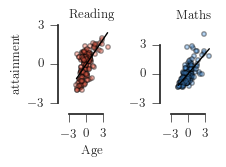

In [110]:
df['Reading'] = zscore(df['Reading'].values)
df['Maths'] = zscore(df['Maths'].values)
df['Age'] = zscore(df['Age'].values)
newX = np.linspace(np.min(df['Age']), np.max(df['Age']), 100)
colours = ['#FA644D', '#4894E0']
i = 0
fig = plt.figure(figsize=(60*mm2inches, 45*mm2inches), dpi=300, tight_layout=True)
           
for outcome in ['Reading', 'Maths']:
    plt.subplot(1, 2, i+1)
    # Adding the linear regression line of best fit
    plt.scatter(df['Age'].values, df[outcome], color=colours[i], s=10, edgecolor='k', alpha=0.4)
    linear_fit = smf.ols(outcome + ' ~ Age', data=df).fit()
    plt.plot(newX, linear_fit.params['Age']*newX, 'k', linewidth=1)
    plt.title(outcome, fontsize=9)
    ax = plt.gca()
    ax.set_xticks(np.linspace(-3, 3, 3))
    ax.set_yticks(np.linspace(-3, 3, 3))
    
    if i == 0:
        plt.xlabel('Age')
        plt.ylabel('attainment')
    i+=1
           
ax.set_axis_bgcolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
sns.despine(offset=8, trim=True)
plt.savefig('./figures/Attainment_vs_age.png', dpi=300)

In [163]:
def load_data(folder, model, threshold, weight, subject): 
    import numpy as np
    
    if weight == '_FA':
        weight_switch = str(0)
    elif weight == '_RD':
        weight_switch = str(1)
    elif weight == '_GFA':
        weight_switch = str(2)
        
    matrix = folder + '_subject_id_' + subject + '/_model_' + model + '/_threshold_' + threshold + '/calc_matrix/mapflow/_calc_matrix' + weight_switch + '/' + subject + weight + '_matrix.txt'
    matrix = np.loadtxt(matrix)
    
    # Exclude label entries 
    entries_to_exclude = [ 0,  1,  2,  3,  9, 10, 14, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
    matrix = np.delete(matrix,entries_to_exclude, axis=0)
    matrix = np.delete(matrix,entries_to_exclude, axis=1)
    
    # Removing NaN values
    matrix[np.isnan(matrix)] = 0
    
    return matrix

In [ ]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

d = []

for subject in df['MRI.ID'].values:
    degrees = list()
    strengths = list()
    densities = list()
    clustering_coefficients = list()
    global_efficiencies = list()
    random_degrees = list()
    random_strengths = list()
    random_densities = list()
    random_clustering_coefficients = list()
    random_global_efficiencies = list()
        
    for threshold in np.arange(0.1, 0.9, 0.1):
        network = load_data(in_folder, 'CSD', str(10), '_FA', subject)
        network[np.isnan(network)] = 0 # removing NaN
        network = bct.threshold_proportional(network, threshold)
        degrees.append(np.mean(bct.degrees_und(network)))
        densities.append(bct.density_und(network))
        strengths.append(np.mean(bct.strengths_und(network)))
        clustering_coefficients.append(np.mean(bct.clustering_coef_wu(network)))
        global_efficiencies.append(np.mean(bct.charpath(bct.distance_wei(bct.weight_conversion(network, 'lengths'))[0])[1]))
        
        # Comparison with random networks
        random_degree = list()
        random_strength = list()
        random_density = list()
        random_clustering_coefficient = list()
        random_global_efficiency = list()
    
        for i in np.arange(0,20): # creating 20 scrambled versions of the original network
            random_network = network.copy()
            random_network = random_network[np.random.permutation(random_network.shape[0])][np.random.permutation(random_network.shape[0])]
            random_degree.append(np.mean(bct.degrees_und(random_network)))
            random_density.append(bct.density_und(random_network))
            random_strength.append(np.mean(bct.strengths_und(random_network)))
            random_clustering_coefficient.append(np.mean(bct.clustering_coef_wu(random_network)[~np.isinf(bct.clustering_coef_wu(random_network))]))
            random_global_efficiency.append(np.mean(bct.charpath(bct.distance_wei(bct.weight_conversion(random_network, 'lengths'))[0])[1]))
        
        random_degrees.append(np.mean(random_degree))
        random_strengths.append(np.mean(random_strength))
        random_densities.append(np.mean(random_density))
        random_clustering_coefficients.append(np.mean(random_clustering_coefficient))
        random_global_efficiencies.append(np.mean(random_global_efficiency))
        
    normed_clustcoefs = np.asarray(clustering_coefficients)/np.asarray(random_clustering_coefficients)
    normed_efficiency = np.asarray(global_efficiencies)/np.asarray(random_global_efficiencies)
        
    d.append({
            'MRI.ID': subject, 
            'degree': np.sum(degrees),
            'density': np.sum(densities),
            'strength': np.sum(strengths),
            'clustering_coefficient': np.sum(clustering_coefficients),
            'global_efficiency': np.sum(global_efficiencies),
            'random_degree': np.sum(random_degrees),
            'random_density': np.sum(random_densities),
            'random_strength': np.sum(random_densities),
            'random_clustering_coefficient': np.sum(random_clustering_coefficients),
            'random_global_efficiency': np.sum(random_global_efficiencies),
            'normed_clustering_coefficient': np.sum(normed_clustcoefs),
            'normed_global_efficiency': np.sum(normed_efficiency)
             })
    
    counter += 1
    w.value = 100*(float(counter)/len(df['MRI.ID'].values))
    
combined_df = pd.merge(pd.DataFrame(d), df, on='MRI.ID')
combined_df = combined_df.set_index('MRI.ID')
combined_df.to_csv('./data/GraphTheory_results.csv')

### Comparison between observed and random networks

In [170]:
from scipy.stats import sem, ttest_ind

In [171]:
def compare_with_ttest(df, measures, xlabel):
    fig = plt.figure(num=None, figsize=(double_column/4, double_column/4), dpi=300, tight_layout=True, facecolor='white')
    sns.distplot(df[measures[0]], kde=False, bins=20, color='firebrick')
    sns.distplot(df[measures[1]], kde=False, bins=20, color='dodgerblue')
    plt.xlabel(xlabel)
    plt.ylabel('')
    ax = plt.gca()
    ax.set_xticks(np.linspace(np.min(combined_df[measures].values), np.max(combined_df[measures].values), 3))
    sns.despine(offset=8, trim=True)

    print('Observed: mean=%.2f, SE=%.3f' % (mean(df[measures[0]]), sem(df[measures[0]])))
    print('Random: mean=%.2f, SE=%.3f' % (mean(df[measures[1]]), sem(df[measures[1]])))

    t,p = ttest_ind(df[measures[0]].values, df[measures[1]].values)
    print('Paired sample t-test: t(%i)=%.2f, p=%.3f' % (len(df)-1, t ,p))

Observed: mean=2023.43, SE=21.756
Random: mean=687.48, SE=7.566
Paired sample t-test: t(143)=58.00, p=0.000


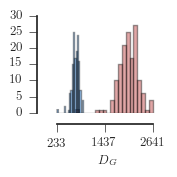

In [172]:
compare_with_ttest(combined_df, ['density', 'random_density'], u'$D_{G}$')

Observed: mean=31.60, SE=0.512
Random: mean=31.60, SE=0.512
Paired sample t-test: t(143)=0.00, p=1.000


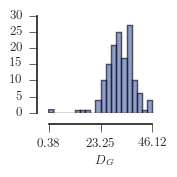

In [173]:
compare_with_ttest(combined_df, ['degree', 'random_degree'], u'$D_{G}$')
plt.savefig('./figures/Degree.png', dpi=300)

Observed: mean=1.17, SE=0.024
Random: mean=0.23, SE=0.007
Paired sample t-test: t(143)=37.54, p=0.000


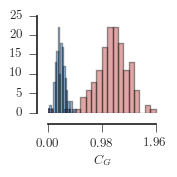

In [174]:
compare_with_ttest(combined_df, ['clustering_coefficient', 'random_clustering_coefficient'], u'$C_{G}$')
plt.savefig('./figures/Clustering_coefficient.png', dpi=300)

Observed: mean=1.09, SE=0.017
Random: mean=0.88, SE=0.017
Paired sample t-test: t(143)=8.61, p=0.000


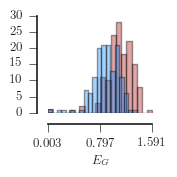

In [175]:
compare_with_ttest(combined_df, ['global_efficiency', 'random_global_efficiency'], u'$E_{G}$')
plt.savefig('./figures/Global_Efficiency.png', dpi=300)

## Influence of nuisance variables

In [209]:
combined_df = pd.read_csv('./data/GraphTheory_results.csv')
combined_df = combined_df.set_index('MRI.ID')
combined_df = combined_df.dropna()

Loading information about motion

In [210]:
motion_df = pd.read_csv('./data/CALM_movement.csv')
motion_df.columns = ['MRI.ID', 'motion', 'volumes']
motion_df = motion_df.set_index('MRI.ID')

Loading brain volume information

In [211]:
ICV_df = pd.read_csv('/imaging/jb07/CALM/T1/ICV.csv')
ICV_df = ICV_df.set_index('MRI.ID')

In [212]:
combined_df = pd.merge(combined_df, motion_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, ICV_df, left_index=True, right_index=True)

Influence of ICV

In [213]:
measures = ['normed_clustering_coefficient', 'normed_global_efficiency', 'Reading', 'Maths']
for measure in measures:
    print measure
    combined_df['ICV'] = zscore(combined_df['ICV'])
    combined_df[measures] = combined_df[measures].apply(zscore)
    fit = smf.ols(measure + ' ~ ICV', data=combined_df).fit()
    print('Simple regression: F(%i,%i)=%.2f, beta=%.2f, p=%.3f' % (fit.df_model, fit.df_resid, fit.fvalue, fit.params['ICV'], fit.pvalues['ICV']))

normed_clustering_coefficient
Simple regression: F(1,141)=14.15, beta=-0.30, p=0.000
normed_global_efficiency
Simple regression: F(1,141)=9.31, beta=-0.25, p=0.003
Reading
Simple regression: F(1,141)=7.95, beta=-0.23, p=0.005
Maths
Simple regression: F(1,141)=1.26, beta=-0.09, p=0.264


Influence of motion

In [214]:
measures = ['normed_clustering_coefficient', 'normed_global_efficiency', 'Reading', 'Maths']
for measure in measures:
    print measure
    combined_df['motion'] = zscore(combined_df['motion'])
    combined_df[measures] = combined_df[measures].apply(zscore)
    fit = smf.ols(measure + ' ~ motion', data=combined_df).fit()
    print('Simple regression: F(%i,%i)=%.2f, beta=%.2f, p=%.3f' % (fit.df_model, fit.df_resid, fit.fvalue, fit.params['motion'], fit.pvalues['motion']))

normed_clustering_coefficient
Simple regression: F(1,141)=1.24, beta=0.09, p=0.268
normed_global_efficiency
Simple regression: F(1,141)=0.34, beta=0.05, p=0.559
Reading
Simple regression: F(1,141)=1.30, beta=-0.10, p=0.256
Maths
Simple regression: F(1,141)=5.22, beta=-0.19, p=0.024


## Relationship with maths and reading scores

Regressing the effect of age

In [215]:
combined_df['Maths_reg'] = zscore(smf.ols('Maths ~ ICV + motion + Age + np.power(Age, 2)', data=combined_df).fit().resid)
combined_df['Reading_reg'] = zscore(smf.ols('Reading ~ ICV + motion + Age + np.power(Age, 2)', data=combined_df).fit().resid)
combined_df['clustering_coefficient_reg'] = zscore(smf.ols('normed_clustering_coefficient ~ ICV + motion + Age + np.power(Age, 2)', data=combined_df).fit().resid)
combined_df['global_efficiency_reg'] = zscore(smf.ols('normed_global_efficiency ~ ICV + motion + Age + np.power(Age, 2)', data=combined_df).fit().resid)

In [216]:
def graphmetric_v_outcome(measure, outcome, colour, label):
    X = combined_df[measure].values
    Y = combined_df[outcome].values
    newX = np.linspace(np.min(X), np.max(X), 100)

    fig = plt.figure(figsize=(single_column, single_column), dpi=300, tight_layout=True)
    plt.scatter(X, Y, s=40, facecolors=colour, edgecolor='k', alpha=0.4)

    # Adding the linear regression line of best fit
    linear_fit = smf.ols(outcome + ' ~ ' + measure, data=combined_df).fit()
    plt.plot(newX, linear_fit.predict({measure:newX}), 'k', linewidth=1)

    plt.xlabel(label)
    plt.ylabel(outcome + '[zscore]')
    plt.savefig(figure_folder + 'IQ_v_' + measure + '.png', dpi=300)
    
    print('beta=%.2f, p=%.3f' % (linear_fit.params[measure], linear_fit.pvalues[measure]))

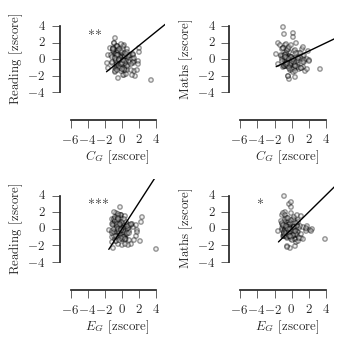

In [217]:
sns.set_style("ticks")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

fig = plt.figure(figsize=(single_column, single_column), dpi=300, tight_layout=True)
counter = 0

for measure in ['clustering_coefficient', 'global_efficiency']:
    for outcome in ['Reading', 'Maths']:
        plt.subplot(2,2,counter+1)
        X = combined_df[measure + '_reg'].values
        Y = combined_df[outcome + '_reg'].values
        newX = np.linspace(np.min(X), np.max(X), 100)

        plt.scatter(X, Y, s=10, facecolors='#D3D3D3', edgecolor='k', alpha=0.4)

        # Adding the linear regression line of best fit
        linear_fit = smf.ols(outcome + ' ~ ' + measure + ' + ICV + motion + Age', data=combined_df).fit()
        plt.plot(newX, linear_fit.params[measure]*newX, 'k', linewidth=1)
        
        ax = plt.gca()
        plt.ylim([-6, 6])
        plt.xlim([-4, 5])
        ax.set_xticks(np.arange(-6, 6, 2))
        ax.set_yticks(np.arange(-4, 5, 2))
        pvalue = linear_fit.pvalues[measure]
        """
        text = u'$\\beta=$' + str(round(linear_fit.params[measure], 2)) + \
        '\n$p=$' + str(round(pvalue, 3)) + \
        '\ncorr-$p=$' + str(round(multipletests(np.repeat(pvalue,4), method='Bonferroni')[1][0], 3))
        ax.text(-4, 3, text)
        """
        pcorr = multipletests(np.repeat(pvalue,4), method='Bonferroni')[1][0]
        if pcorr < 0.001:
            text = '***'
            ax.text(-4, 3, text)
        elif pcorr < 0.01:
            text = '**'
            ax.text(-4, 3, text)
        elif pcorr < 0.05:
            text = '*'
            ax.text(-4, 3, text)
            
        if re.search('clustering_coefficient', measure):
            plt.xlabel('$C_{G}$ [zscore]')
        elif re.search('efficiency', measure):
            plt.xlabel('$E_{G}$ [zscore]')
        plt.ylabel(outcome.split('_')[0] + ' [zscore]')
        sns.despine(offset=8, trim=True)
        plt.tight_layout()
        counter += 1
        
plt.savefig('./figures/Regression_results_woAge.png', dpi=300)

In [218]:
combined_df['Maths'] = zscore(combined_df['Maths'].values)
combined_df['Reading'] = zscore(combined_df['Reading'].values)
combined_df['clustering_coefficient'] = zscore(combined_df['clustering_coefficient'].values)
combined_df['global_efficiency'] = zscore(combined_df['global_efficiency'].values)

for outcome in ['Reading', 'Maths']:
    for predictor in ['clustering_coefficient', 'global_efficiency']:
        print(outcome)
        print(predictor)
        fit = smf.ols(outcome + ' ~ ' + predictor + ' + ICV + motion', data=combined_df).fit()
        adjusted_fit = smf.ols(outcome + ' ~ ' + predictor + ' + ICV + motion + Age + np.power(Age,2)', data=combined_df).fit()
        print('Simple model: beta=%.2f, p=%.3f' % (fit.params[predictor], 4*fit.pvalues[predictor]))
        print('Adjusted model: beta=%.2f, p=%.3f' % (adjusted_fit.params[predictor], 4*adjusted_fit.pvalues[predictor]))

Reading
clustering_coefficient
Simple model: beta=0.39, p=0.000
Adjusted model: beta=0.22, p=0.005
Reading
global_efficiency
Simple model: beta=0.47, p=0.000
Adjusted model: beta=0.29, p=0.000
Maths
clustering_coefficient
Simple model: beta=0.33, p=0.000
Adjusted model: beta=0.13, p=0.182
Maths
global_efficiency
Simple model: beta=0.40, p=0.000
Adjusted model: beta=0.19, p=0.019


## Mediation analysis

In [219]:
combined_df['Maths_reg'] = zscore(smf.ols('Maths ~ ICV + motion', data=combined_df).fit().resid)
combined_df['Reading_reg'] = zscore(smf.ols('Reading ~ ICV + motion', data=combined_df).fit().resid)
combined_df['clustering_coefficient_reg'] = zscore(smf.ols('normed_clustering_coefficient ~ ICV + motion', data=combined_df).fit().resid)
combined_df['global_efficiency_reg'] = zscore(smf.ols('normed_global_efficiency ~ ICV + motion', data=combined_df).fit().resid)

In [220]:
stats_df = combined_df[['Maths_reg', 'Reading_reg', 'clustering_coefficient_reg', 'global_efficiency_reg', 'Age']].copy()
stats_df.to_csv('./data/Mediation_data.csv')

## Analysis of regional association

In [ ]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

clustering_coefs = []
efficiencies = []

for subject in df['MRI.ID'].values:
    individual_clustering_coefs = []
    individual_efficiencies = []

    for threshold in np.arange(0.1, 0.9, 0.1):
            network = load_data(in_folder, 'CSD', str(10), '_FA', subject)
            network[np.isnan(network)] = 0 # removing NaN
            network = bct.threshold_proportional(network, threshold)
            individual_clustering_coefs.append(bct.clustering_coef_wu(network))
            individual_efficiencies.append(bct.efficiency_wei(bct.weight_conversion(network, 'lengths'), local=True))
    
    clustering_coefs.append(np.mean(np.asarray(individual_clustering_coefs), axis=0))
    efficiencies.append(np.mean(np.asarray(individual_efficiencies), axis=0))
    
    counter += 1
    w.value = 100*(float(counter)/len(df['MRI.ID'].values))
    
clustering_coefs = np.rollaxis(np.asarray(clustering_coefs), 1, 0)
efficiencies = np.rollaxis(np.asarray(efficiencies), 1, 0)

Creating zscored means across participants for topographic plots

In [157]:
np.savetxt('./data/clust_coef_regional.txt', zscore(np.mean(clustering_coefs, axis=1)))
np.savetxt('./data/efficiency_regional.txt', zscore(np.mean(efficiencies, axis=1)))

In [ ]:
counter = 0
labels = ['efficiencies', 'clustering_coefs', 'efficiencies', 'clustering_coefs']
regions = pd.read_csv('./data/DK_labels.txt', header=None)[0].values

for outcome_measure in ['Maths_reg', 'Reading_reg']:
    for node_measure in [efficiencies, clustering_coefs]:
        # Selecting the regions in the training data
        outcome = zscore(smf.ols(outcome_measure + ' ~ ICV + motion + Age + np.power(Age,2)', data=combined_df).fit().resid.values)
        pvalues = []
        betas = []
        
        for i in np.arange(0, node_measure.shape[0]):
                stats_df = pd.DataFrame({'predictor': node_measure[i, :], 'outcome':zscore(combined_df[outcome_measure])})
                fit = smf.ols('outcome ~ predictor', data=stats_df).fit()
                betas.append(fit.params['predictor'])
                
        betas = np.asarray(betas)
        betas[np.isnan(betas)] = 0
        betas[betas < 0] = 0
        
        np.savetxt('./data/betas_' + outcome_measure + '_' + labels[counter] + '.txt', betas)
        
        results_df = pd.DataFrame({'beta':np.asarray(betas).round(2), 'region':regions}).sort_values('beta', ascending=False)
        print(outcome_measure)
        print(labels[counter])
        print('strongest positive regions')
        print(results_df[0:3])
        print('\n')
        counter += 1
        

## Knock-down analysis

In [231]:
combined_df = pd.read_csv('./data/GraphTheory_results.csv')
combined_df = combined_df.set_index('MRI.ID')
combined_df = combined_df.dropna()

In [232]:
all_networks = np.rollaxis(np.asarray([bct.threshold_absolute(load_data(in_folder, 'CSD', str(10), '_FA', subject), 0.1) for subject in combined_df.index]), 0, 3)
mean_network = np.mean(all_networks, axis=2)

Plotting the adjacency matrix

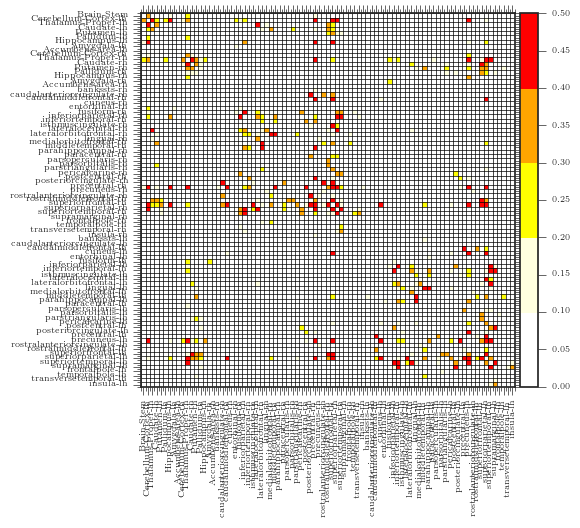

In [233]:
labels = pd.read_csv('./data/DK_labels.txt', header=None)[0].values

rcParams['xtick.labelsize'] = 6  
rcParams['ytick.labelsize'] = 6 

from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# make a color map of fixed colors
cmap = colors.ListedColormap(['w', 'lightyellow', 'yellow', 'orange', 'red'])
bounds=[0,.1,.2,.3,.4]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(150*mm2inches, 150*mm2inches), dpi=300, tight_layout=True)
im = plt.imshow(mean_network, interpolation='None', cmap=cmap)
plt.clim(0,.5)

ax = plt.gca()

# Adding the grid and labels
ax.set_xticks(np.arange(0, len(labels), 1));
ax.set_yticks(np.arange(0, len(labels), 1));
ax.set_xticklabels(np.arange(1, len(labels)+1, 1));
ax.set_yticklabels(np.arange(1, len(labels)+1, 1));
ax.set_xticks(np.arange(-.5, len(labels), 1), minor=True);
ax.set_yticks(np.arange(-.5, len(labels), 1), minor=True);
ax.grid(which='minor', color='k', linestyle='-', linewidth=.5)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)

# Adding the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.yaxis.set_label_position('right')
plt.savefig('./figures/Adjacency_Matrix.png', dpi=300)

Identifying the hub nodes

In [234]:
degree_df = pd.DataFrame({'degree': bct.degrees_und(mean_network), 'label': labels})
degree_df['hub'] = ['hub' if entry == 1 else 'periphery' for entry in 1*(degree_df['degree'] > np.mean(degree_df['degree']) + np.std(degree_df['degree']))]

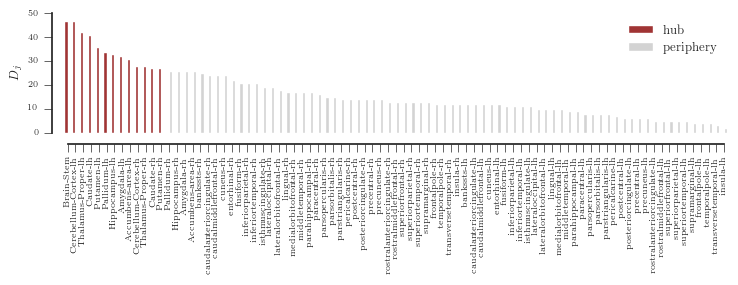

In [235]:
fig = plt.figure(figsize=(190*mm2inches, 75*mm2inches), dpi=300, tight_layout=True)
h = sns.barplot(x='label', y='degree', hue='hub', palette=sns.color_palette(['#b22222', '#d3d3d3']), edgecolor='w', data=degree_df.sort_values('degree', ascending=False))
plt.legend(title = None)
sns.despine(offset=8, trim=True)
plt.gca().set_xticklabels(degree_df['label'].values, rotation=90);
plt.xlabel(' ')
plt.ylabel('$D_{j}$')
plt.tight_layout()
plt.savefig('./figures/Group_degrees.png', dpi=300)

In [245]:
def submit_graph_calc_to_cluster(out_directory, missing_nodes, attack_type, rep, target_network):

    network_filename = out_directory + 'group_network_' + str(missing_nodes) + '_' + attack_type + '_' + str(rep) + '.txt'
    metrics_filename = out_directory + 'graph_metrics_' + str(missing_nodes) + '_' + attack_type + '_' + str(rep) + '.txt'
    script_filename = out_directory + str(missing_nodes) + '_' + attack_type +  '_' + str(rep) + '.sh'
    np.savetxt(network_filename, target_network)
    
    cmd = 'python ' + os.getcwd() + '/calculate_graph_metrics.py' + \
            ' --network_file ' + network_filename + \
            ' --out_filename ' + metrics_filename

    file = open(script_filename, 'w')
    file.write(cmd)
    file.close()

    cmd = 'qsub ' + script_filename
    call(cmd, shell=True)
    
    return metrics_filename

In [ ]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)

out_directory =  '/imaging/jb07/CALM/LearningConnectome/'
hub_nodes = np.where(degree_df['hub'] == 'hub')[0]
peripheral_nodes = np.where(degree_df['hub'] == 'periphery')[0]
value = 0.001
max_repetitions = 40
maximum = 20
total_count = 0
filenames = []

for attack_type in ['random', 'hub', 'peripheral']:
    missing_nodes = 1

    for missing_nodes in range(1, maximum): # increase the number of missing nodes
        average_clusterings = []
        global_efficiencies = []

        # repeat the calculation at each step to remove the effect of any particular node:
        for rep in np.arange(0, max_repetitions): 

            target_network = mean_network.copy()
            if attack_type == 'random':
                target_network[np.random.randint(len(target_network), size=missing_nodes),:] = value
                target_network[:,np.random.randint(len(target_network), size=missing_nodes)] = value
            if attack_type == 'hub':
                target_network[np.random.permutation(hub_nodes)[0:missing_nodes],:] = value
                target_network[:,np.random.permutation(hub_nodes)[0:missing_nodes]] = value
            if attack_type == 'peripheral':
                target_network[np.random.permutation(peripheral_nodes)[0:missing_nodes],:] = value
                target_network[:,np.random.permutation(peripheral_nodes)[0:missing_nodes]] = value
            
            filenames.append(submit_graph_calc_to_cluster(out_directory, missing_nodes, attack_type, rep, target_network))
        
            total_count += 1
            w.value = 100*(float(total_count + 2)/(3*maximum*max_repetitions))
            
        missing_nodes += 1
        time.sleep(30)
        
while not all([os.path.isfile(filename) for filename in filenames]):
    time.sleep(0.1)

Loading the results

In [247]:
attack_results = []

for filename in filenames:
    graph_metrics = np.loadtxt(filename)
    filename = filename.split('/')[-1]
    missing_nodes = filename.split('_')[2]
    attack_type = filename.split('_')[3]
    rep = filename.split('_')[4].split('.')[0]
    
    # Average the results over repetitions and add them to the dataframe
    attack_results.append({'nodes_missing': missing_nodes,
                       'attack_type': attack_type,
                       'rep': rep,
                       'average_clustering': graph_metrics[0],
                       'global_efficiency': graph_metrics[1]})
    
pd.DataFrame(attack_results).to_csv('./data/Attack_results.csv')

attack_df = pd.read_csv('./data/Attack_results.csv')
attack_df = attack_df.groupby(['attack_type', 'nodes_missing'], as_index=False).mean()

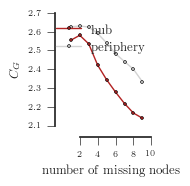

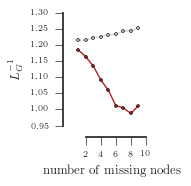

In [248]:
counter = 0
attack_df = attack_df[attack_df['nodes_missing'] < 10
                     ]
for outcome in ['average_clustering', 'global_efficiency']:
    fig = plt.figure(figsize=(50*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)

    x = attack_df[attack_df['attack_type'] == 'hub']['nodes_missing']
    y = attack_df[attack_df['attack_type'] == 'hub'][outcome]
    plt.plot(x, y, '-o', color='#b22222', markersize=2, markerfacecolor='#b22222')
    x = attack_df[attack_df['attack_type'] == 'peripheral']['nodes_missing']
    y = attack_df[attack_df['attack_type'] == 'peripheral'][outcome]
    plt.plot(x, y, '-o', color='#d3d3d3', markersize=2, markerfacecolor='#d3d3d3')
    plt.xlim([0.5, 10.5])

    if counter == 0:
        plt.legend(['hub', 'periphery', 'random'])
    plt.xlabel('number of missing nodes')
    if outcome == 'average_clustering':
        plt.ylabel('$C_{G}$')
    else:
        plt.ylabel('$L_{G}^{-1}$')
    sns.despine(offset=8, trim=True)
    plt.savefig('./figures/KnockDown_' + outcome + '.png', dpi=300)
    counter += 1

## Relating hub vs peripheral strength to academic attainment outcomes

In [249]:
combined_df = pd.read_csv('./data/GraphTheory_results.csv')
combined_df = combined_df.set_index('MRI.ID')
combined_df = combined_df.dropna()

motion_df = pd.read_csv('./data/CALM_movement.csv')
motion_df.columns = ['MRI.ID', 'motion', 'volumes']
motion_df = motion_df.set_index('MRI.ID')

ICV_df = pd.read_csv('/imaging/jb07/CALM/T1/ICV.csv')
ICV_df = ICV_df.set_index('MRI.ID')

combined_df = pd.merge(combined_df, motion_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, ICV_df, left_index=True, right_index=True)
combined_df = combined_df.sort_index()

In [250]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

clustering_coefs = []
efficiencies = []

for subject in combined_df.index:
    individual_clustering_coefs = []
    individual_efficiencies = []

    for threshold in np.arange(0.1, 0.9, 0.1):
            network = load_data(in_folder, 'CSD', str(10), '_FA', subject)
            network[np.isnan(network)] = 0 # removing NaN
            network = bct.threshold_proportional(network, threshold)
            individual_clustering_coefs.append(bct.clustering_coef_wu(network))
            individual_efficiencies.append(bct.efficiency_wei(bct.weight_conversion(network, 'lengths'), local=True))
    
    clustering_coefs.append(np.mean(np.asarray(individual_clustering_coefs), axis=0))
    efficiencies.append(np.mean(np.asarray(individual_efficiencies), axis=0))
    
    counter += 1
    w.value = 100*(float(counter)/len(df['MRI.ID'].values))
    
clustering_coefs = np.rollaxis(np.asarray(clustering_coefs), 1, 0)
efficiencies = np.rollaxis(np.asarray(efficiencies), 1, 0)

In [251]:
combined_df['hub_clustering'] = np.mean(clustering_coefs[hub_nodes, :], axis=0)
combined_df['hub_efficiency'] = np.mean(efficiencies[hub_nodes, :], axis=0)
combined_df['peripheral_clustering'] = np.mean(clustering_coefs[peripheral_nodes, :], axis=0)
combined_df['peripheral_efficiency'] = np.mean(efficiencies[peripheral_nodes, :], axis=0)
combined_df = combined_df.apply(zscore)

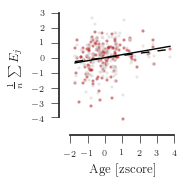

In [252]:
measure = 'Age'
colours = ['#b22222', '#d3d3d3']
linestyles = ['solid', 'dashed']

counter = 0

fig = plt.figure(figsize=(50*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)

for outcome in ['hub_efficiency', 'peripheral_efficiency']:
    X = combined_df['Age'].values
    Y = combined_df[outcome].values
    newX = np.linspace(np.min(X), np.max(X), 100)

    plt.scatter(X, Y, s=2, facecolors=colours[counter], edgecolor=colours[counter], alpha=0.4)

    # Adding the linear regression line of best fit
    linear_fit = smf.ols(outcome + ' ~ Age', data=combined_df).fit()
    plt.plot(newX, linear_fit.params['Age']*newX, 'k', linewidth=1, linestyle=linestyles[counter])
    sns.despine(offset=8, trim=True)
    plt.xlabel('Age [zscore]')
    plt.ylabel(r'$\frac{1}{n}\sum{E_{j}}$')
    counter += 1
    plt.savefig('./figures/Age_vs_efficiency.png', dpi=300)

In [253]:
for measure in ['hub_clustering', 'peripheral_clustering', 'hub_efficiency', 'peripheral_efficiency']:
    fit = smf.ols(measure + ' ~ Age + ICV + motion', data=combined_df).fit()
    print('Age relationship: beta=%.2f, p=%.3f' % (fit.params['Age'], 4*fit.pvalues['Age']))

Age relationship: beta=0.17, p=0.236
Age relationship: beta=0.30, p=0.001
Age relationship: beta=0.27, p=0.006
Age relationship: beta=0.25, p=0.014


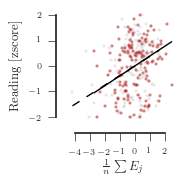

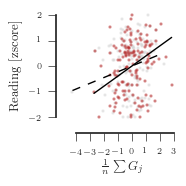

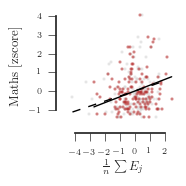

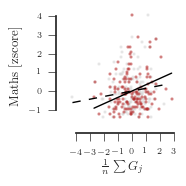

In [257]:
colours = ['#d3d3d3', '#b22222'] #['#b22222', '#d3d3d3']
linestyles = ['dashed', 'solid'] #['solid', 'dashed']

for outcome in ['Reading', 'Maths']:
    for metric in ['efficiency', 'clustering']:
        counter = 0

        fig = plt.figure(figsize=(50*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)

        for region in ['hub_', 'peripheral_']:
            measure = region + metric
            X = zscore(smf.ols(measure + ' ~ motion + ICV + Age + np.power(Age, 2)', data=combined_df).fit().resid.values)
            Y = combined_df[outcome].values
            newX = np.linspace(np.min(X), np.max(X), 100)

            plt.scatter(X, Y, s=2, facecolors=colours[counter], edgecolor=colours[counter], alpha=0.4)

            # Adding the linear regression line of best fit
            linear_fit = smf.ols(outcome + ' ~ ' + measure + ' + ICV + motion', data=combined_df).fit()
            plt.plot(newX, linear_fit.params[measure]*newX, 'k', linewidth=1, linestyle=linestyles[counter])
            sns.despine(offset=8, trim=True)
            if metric == 'clustering':
                plt.xlabel(r'$\frac{1}{n}\sum{G_{j}}$')
            if metric == 'efficiency':
                plt.xlabel(r'$\frac{1}{n}\sum{E_{j}}$')
            plt.ylabel(outcome + ' [zscore]')
            counter += 1
            plt.savefig('./figures/' + outcome + '_vs_' + metric + '.png', dpi=300)

In [916]:
for measure in ['peripheral_clustering','hub_clustering', 'peripheral_efficiency', 'hub_efficiency']:
    fit = smf.ols('Reading ~ ' + measure + ' + ICV + motion', data=combined_df).fit()
    print('Age relationship: beta=%.2f, p=%.3f' % (fit.params[measure], 8*fit.pvalues[measure]))

Age relationship: beta=0.38, p=0.000
Age relationship: beta=0.22, p=0.109
Age relationship: beta=0.38, p=0.000
Age relationship: beta=0.34, p=0.001


In [918]:
for measure in ['peripheral_clustering','hub_clustering', 'peripheral_efficiency', 'hub_efficiency']:
    fit = smf.ols('Maths ~ ' + measure + ' + ICV + motion', data=combined_df).fit()
    print('Age relationship: beta=%.2f, p=%.3f' % (fit.params[measure], 8*fit.pvalues[measure]))

Age relationship: beta=0.31, p=0.005
Age relationship: beta=0.04, p=5.201
Age relationship: beta=0.29, p=0.011
Age relationship: beta=0.16, p=0.560


In [898]:
measures = ['hub_clustering', 'peripheral_clustering', 'hub_efficiency', 'peripheral_efficiency', 'Age', 'Maths', 'Reading']
combined_df[measures].to_csv('./data/hub_mediation.csv')

## Running comparison with TBSS

Loading behavioural and nuisance data

In [136]:
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/CALM_behavioural_data_Apr17.csv')[['ID No.', 'Age_in_months', 'WIAT_Numerical_Std', 'WIAT_Reading_Std']]
df.columns = ['ID', 'Age', 'Maths', 'Reading']
df = df.dropna()
df['MRI.ID'] = [get_imaging_ID(str(int(ID)), './data/MRI_ID_match_Aug17.csv') for ID in df['ID'].values]
df = df.set_index('MRI.ID')

included_df = pd.read_csv('./data/GraphTheory_results.csv')
motion_df = pd.read_csv('./data/CALM_movement.csv')
motion_df.columns = ['MRI.ID', 'motion', 'volumes']
motion_df = motion_df.set_index('MRI.ID')

ICV_df = pd.read_csv('/imaging/jb07/CALM/T1/ICV.csv')
ICV_df = ICV_df.set_index('MRI.ID')

combined_df = pd.merge(df, motion_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, ICV_df, left_index=True, right_index=True)
combined_df = combined_df.sort_index()
combined_df = combined_df[combined_df.index.isin(included_df['MRI.ID'])]

In [50]:
def create_design_mat(df, filename):
    design_mat = open(filename, 'w')
    design_mat.write('/NumWaves ' + str(np.shape(df)[1]) + '\n')
    design_mat.write('/NumPoints ' + str(np.shape(df)[0]) + '\n')
    design_mat.write('/Matrix \n')
    
    for row in df.values:
        string = ''
        for value in row:
           string = string + str(value) + ' '
        design_mat.write(string + '\n')
        
    design_mat.close()

In [61]:
def create_design_con(filename):
    design = """
    /ContrastName1 "G1 > G2"
    /ContrastName2 "G1 < G2"
    /NumWaves 6
    /NumContrasts 2

    /Matrix
    1 -1 0 0 0 0
    -1 1 0 0 0 0
    """

    design_file = open(filename, 'w')
    design_file.write(design)
    design_file.close()

Group assignment based on percentiles

In [357]:
for limit in [[50,50], [25,75], [15,85], [10, 90]]:
    for outcome in ['Reading', 'Maths']:

        lower_limit = limit[0]
        upper_limit = limit[1]

        tbss_folder = '/imaging/jb07/CALM/LearningConnectome/' + str(lower_limit) + '-vs-' + str(upper_limit) + '_' + outcome + '/'

        if not os.path.isdir(tbss_folder):
            os.mkdir(tbss_folder)
            os.mkdir(tbss_folder + '/FA/')
            os.mkdir(tbss_folder + '/stats/')

        # Moving the files to the tbss folder according to their percentile ranking
        filename = lambda subject: '/imaging/jb07/CALM/Modularity/connectome/_subject_id_' + subject + '/dwi_preproc/dtifit/' + subject + '_FA.nii.gz'
        df = combined_df.copy()
        percentile_upper = df[df[outcome] > np.percentile(df[outcome], q=upper_limit)]
        percentile_upper = percentile_upper.assign(group=np.repeat(0, percentile_upper.shape[0]))
        percentile_lower = df[df[outcome] < np.percentile(df[outcome], q=lower_limit)]
        percentile_lower = percentile_lower.assign(group=np.repeat(1, percentile_lower.shape[0]))
        tbss_df = pd.concat([percentile_lower, percentile_upper]).sort_index()
        tbss_df[['group', 'Maths', 'Reading', 'Age', 'motion', 'ICV']].to_csv(tbss_folder + 'group_assignment.csv')
        
        for subject in tbss_df.index:
            copyfile(filename(subject), tbss_folder + '/FA/' + subject + '_FA.nii.gz')
        
        percentile_lower[['Age', 'motion', 'ICV']] = percentile_lower[['Age', 'motion', 'ICV']] - percentile_lower[['Age', 'motion', 'ICV']].mean()
        percentile_upper[['Age', 'motion', 'ICV']] = percentile_upper[['Age', 'motion', 'ICV']] - percentile_upper[['Age', 'motion', 'ICV']].mean()
        tbss_df = pd.concat([percentile_lower, percentile_upper]).sort_index()
        

        # Creating design matrix and contrast file
        df = pd.DataFrame(np.vstack([tbss_df['group'],
               1*(tbss_df['group'].values == 0),
               tbss_df['Age'].values,
               tbss_df['motion'].values,
               tbss_df['ICV'].values,
               np.ones(tbss_df['group'].shape)]).transpose())

        create_design_mat(df, tbss_folder + '/stats/design.mat')
        create_design_con(tbss_folder + '/stats/design.con')

        # Submitting the command to the cluster
        cmd = "cd " + tbss_folder + "\n" + \
        "tbss_2_reg -t /imaging/jb07/CALM/CALM_FA_template.nii.gz \n" + \
        "sleep 600 # wait for registration to finish \n" + \
        "tbss_3_postreg -S \n" + \
        "tbss_4_prestats 0.2 \n" + \
        "randomise -i " + tbss_folder + "/stats/all_FA_skeletonised.nii.gz " + \
        "-m " + tbss_folder + "stats/mean_FA_mask.nii.gz " + \
        "-d " + tbss_folder + "stats/design.mat " + \
        "-t " + tbss_folder + "stats/design.con " + \
        "-o " + tbss_folder + "stats/tbss " + \
        "--T2 -n 5000"
        filename = '/imaging/jb07/CALM/LearningConnectome/scripts/' + str(lower_limit) + '-vs-' + str(upper_limit) + '_' + outcome + '.sh'
        file = open(filename, 'w')
        file.write(cmd)
        file.close()

        cmd = 'qsub ' + filename
        #call(cmd, shell=True)

Creating an overview table that compares the groups on nuisance variables

In [359]:
dfs = []
stats_df = []

for limit in [[50,50], [25,75], [15,85], [10, 90]]:
    for outcome in ['Reading', 'Maths']:
        tbss_folder = '/imaging/jb07/CALM/LearningConnectome/' + str(limit[0]) + '-vs-' + str(limit[1]) + '_' + outcome + '/'
        tbss_df = pd.read_csv(tbss_folder + 'group_assignment.csv')[['group', outcome, 'Age', 'motion', 'ICV']]
        tbss_df['ICV'] = tbss_df['ICV']/10**3
        tbss_df['split'] = str(limit[0]) + '_vs_' + str(limit[1])
        for measure in [outcome, 'Age', 'motion', 'ICV']:
            group1 = tbss_df[tbss_df['group'] == 0][measure].values
            group2 = tbss_df[tbss_df['group'] == 1][measure].values
            t,p = ttest_ind(group1, group2)
            stats_df.append({'split': str(limit[0]) + '-vs-' + str(limit[1]),
                             'outcome': outcome,
                             'measure': measure,
                             't': round(t, 2),
                             'p': round(p, 3)})
    
        dfs.append(tbss_df)

In [360]:
stats_df = pd.DataFrame(stats_df)

In [361]:
results = np.hstack([stats_df.sort_values('split')[stats_df['measure'] == measure]['t'].values, stats_df.sort_values('split')[stats_df['measure'] == measure]['p'].values])
results = np.hstack([results[0], results[4], results[1], results[5], results[2], results[6], results[3], results[7]])

In [362]:
mean_df = pd.concat(dfs).groupby(['split', 'group']).mean().round(2)
std_df = pd.concat(dfs).groupby(['split', 'group']).std().round(3)

In [363]:
overview_df = pd.DataFrame(np.hstack([mean_df.values, std_df.values]))
overview_df['n'] = pd.concat(dfs).groupby(['split', 'group'])['group'].value_counts().values
measures = ['Maths', 'Age', 'motion', 'ICV']
overview_df.columns = np.hstack([[measure + '_mean' for measure in measures], [measure + '_std' for measure in measures], ['n']])

for measure in measures:
    results = np.hstack([stats_df.sort_values('split')[stats_df['measure'] == measure]['t'].values, stats_df.sort_values('split')[stats_df['measure'] == measure]['p'].values])
    overview_df[measure + '_stat'] = np.hstack([results[0], results[4], results[1], results[5], results[2], results[6], results[3], results[7]])

In [364]:
print(overview_df[np.hstack(['n', np.hstack([[measure + '_mean', measure + '_std', measure + '_stat'] for measure in measures])])].to_latex())

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
{} &   n &  Maths\_mean &  Maths\_std &  Maths\_stat &  Age\_mean &  Age\_std &  Age\_stat &  motion\_mean &  motion\_std &  motion\_stat &  ICV\_mean &  ICV\_std &  ICV\_stat \\
\midrule
0 &  13 &      116.31 &     12.970 &       15.02 &    113.46 &   18.897 &    -1.000 &         0.99 &       0.348 &       -0.990 &   1733.90 &  226.087 &    -0.410 \\
1 &  13 &       58.46 &      4.960 &        0.00 &    120.38 &   16.158 &     0.325 &         1.19 &       0.659 &        0.333 &   1761.45 &   83.049 &     0.684 \\
2 &  20 &      111.80 &     12.168 &       17.54 &    116.50 &   19.883 &    -0.400 &         1.00 &       0.312 &       -1.900 &   1757.85 &  186.921 &    -0.110 \\
3 &  20 &       60.45 &      4.828 &        0.00 &    118.75 &   15.057 &     0.689 &         1.28 &       0.595 &        0.065 &   1762.68 &   70.057 &     0.914 \\
4 &  31 &      106.45 &     12.179 &       18.10 &    111.68 &   21.603 &    -1.170 &         1.05 &       

Group assignment based on scaled scores

In [210]:
for outcome in ['Maths']:
    tbss_folder = '/imaging/jb07/CALM/LearningConnectome/Absolute_Assignment_' + outcome + '/'
    
    if not os.path.isdir(tbss_folder):
        os.mkdir(tbss_folder)
        os.mkdir(tbss_folder + '/FA/')
        
    filename = lambda subject: '/imaging/jb07/CALM/Modularity/connectome/_subject_id_' + subject + '/dwi_preproc/dtifit/' + subject + '_FA.nii.gz'
    higher_group = combined_df[(combined_df[outcome] > 90)]
    higher_group = higher_group.assign(group=np.repeat(0, higher_group.shape[0]))
    #higher_group[['Age', 'motion', 'ICV']] = higher_group[['Age', 'motion', 'ICV']] - higher_group[['Age', 'motion', 'ICV']].mean()
    lower_group = combined_df[combined_df[outcome] < 70]
    lower_group = lower_group.assign(group=np.repeat(1, lower_group.shape[0]))
    #lower_group[['Age', 'motion', 'ICV']] = lower_group[['Age', 'motion', 'ICV']] - lower_group[['Age', 'motion', 'ICV']].mean()
    tbss_df = pd.concat([lower_group, higher_group]).sort_index()


    for subject in tbss_df.index:
        copyfile(filename(subject), tbss_folder + '/FA/' + subject + '_FA.nii.gz')

    tbss_df[['Age', 'motion', 'ICV']] = tbss_df[['Age', 'motion', 'ICV']] - tbss_df[['Age', 'motion', 'ICV']].mean()
    tbss_df[['group', 'Age', 'motion', 'ICV']].to_csv(tbss_folder + outcome + '_absolute_assignment.csv')

In [220]:
tbss_df['ICV'] = tbss_df['ICV']/10**3
tbss_df.groupby('group').mean()[['Age', 'Maths', 'motion', 'ICV']].round(2)

,Age,Maths,motion,ICV
group,,,,
0,108.33,103.46,1.00,1.77
1,117.47,63.07,1.17,1.76


In [221]:
tbss_df.groupby('group').std()[['Age', 'Maths', 'motion', 'ICV']].round(3)

,Age,Maths,motion,ICV
group,,,,
0,21.043,12.363,0.450,0.141
1,16.506,5.471,0.591,0.070


In [213]:
for measure in ['Age', 'Maths', 'motion', 'ICV']:
    t,p = ttest_ind(tbss_df[tbss_df['group'] == 1][measure].values, tbss_df[tbss_df['group'] == 0][measure].values)
    print('t-test: t=%.2f, p=%.3f' % (t,p))

t-test: t=1.96, p=0.054
t-test: t=-16.66, p=0.000
t-test: t=1.35, p=0.183
t-test: t=-0.48, p=0.631


In [260]:
from nilearn import plotting
import nibabel as nib

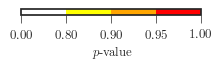

In [121]:
import matplotlib.pyplot as plt
from matplotlib import colors

rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9


fig = plt.figure(figsize=(2, .4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# make a color map of fixed colors
cmap = colors.ListedColormap(['w', 'yellow', 'orange', 'red'])
bounds=[0,.8,.9,.95,1.]
norm = colors.BoundaryNorm(bounds, cmap.N)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                               norm=norm,
                                orientation='horizontal')
cb1.set_label('$p$-value')
plt.savefig('./figures/segmented_colorbar.png', dpi=300)

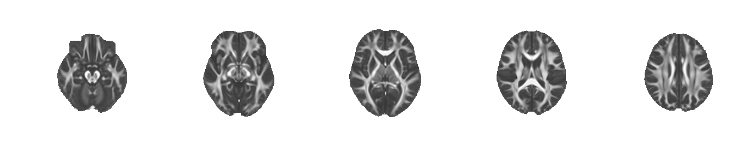

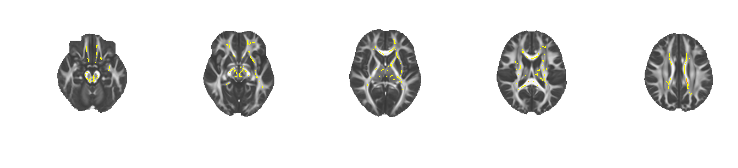

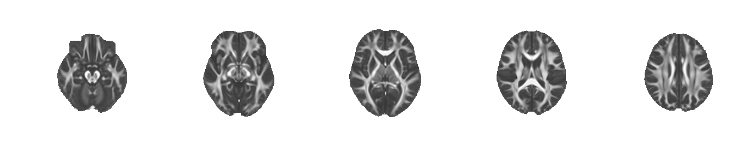

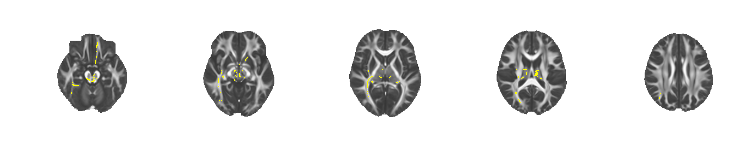

In [356]:
bg = nib.load('/imaging/jb07/CALM/CALM_FA_template.nii.gz').get_data()

for outcome in ['Reading', 'Maths']:
    for contrast in ['1', '2']:
        data = nib.load('/imaging/jb07/CALM/LearningConnectome/Absolute_Assignment_' + outcome + '/stats/tbss_tfce_corrp_tstat' + contrast + '.nii.gz').get_data()
        data[data < 0.8] = 0
        data = np.ma.masked_where(data == 0, data)
        
        bg = np.ma.masked_where(bg == 0, bg)
        
        fig = plt.figure(figsize=(190*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)
        subplot = 0

        for current_slice in [60,70,80,90,100]:
            plt.subplot(1,5,subplot+1)
            bg_img = plt.imshow(np.flipud(bg[..., current_slice].transpose()), cmap='Greys_r', figure=fig, alpha=0.8)
            stat_img = plt.imshow(np.flipud(data[..., current_slice].transpose()), 
                                  interpolation='none',
                                  cmap=cmap, 
                                  norm=norm,
                                  figure=fig)
            plt.axis('off')
            subplot += 1
        plt.savefig('./figures/' + outcome + contrast + '.png', dpi=300)

Plotting the results for percentile assignments

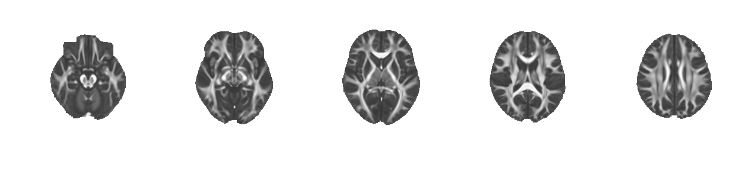

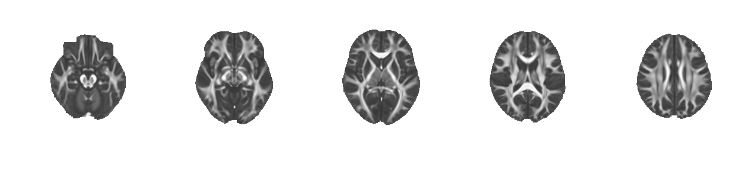

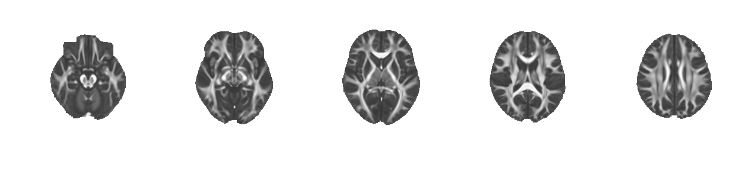

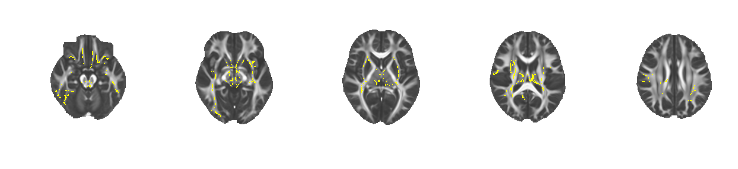

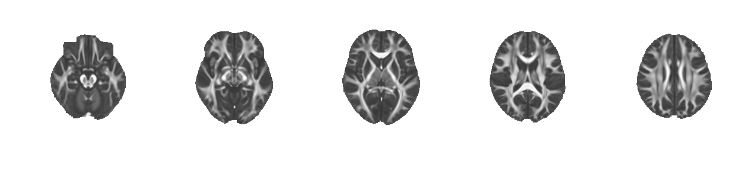

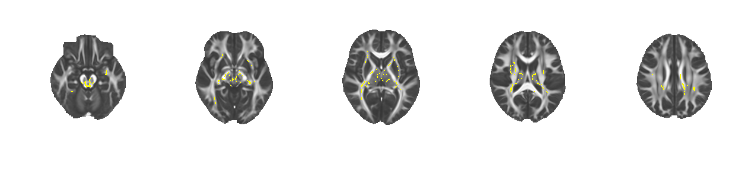

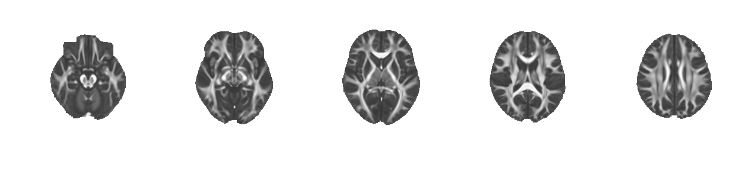

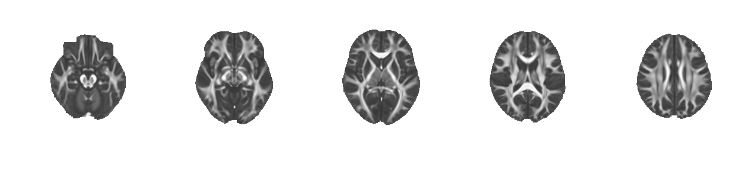

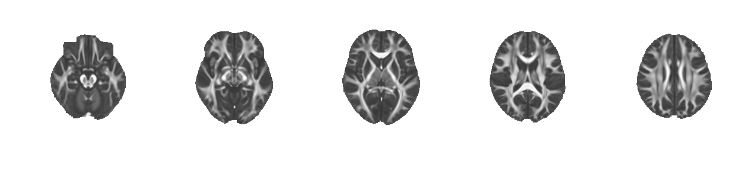

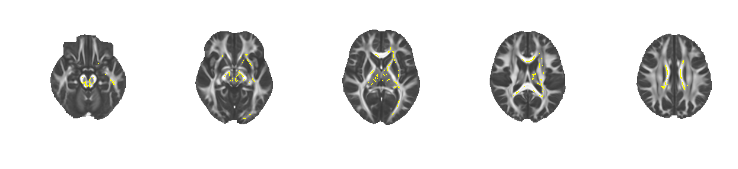

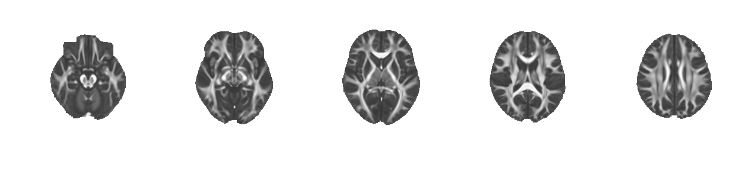

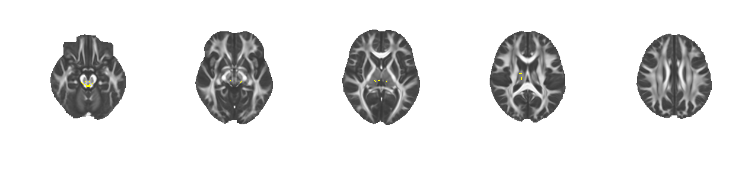

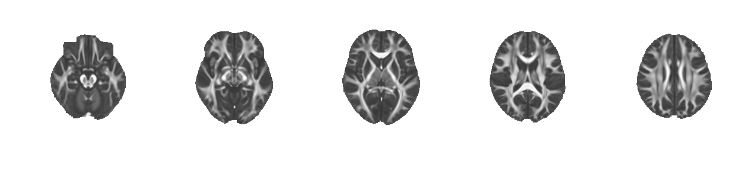

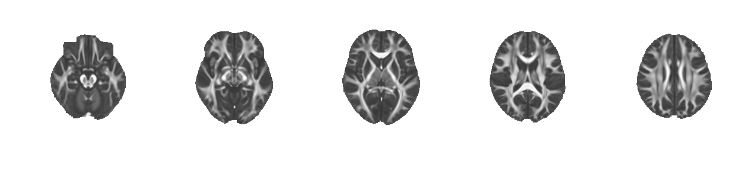

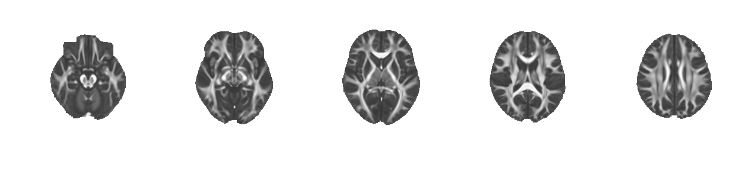

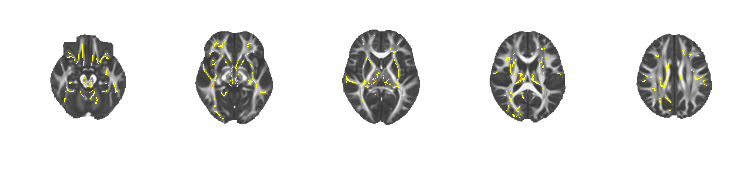

In [376]:
bg = nib.load('/imaging/jb07/CALM/CALM_FA_template.nii.gz').get_data()

for limit in [[10,90], [15,85], [25,75], [50, 50]]:
    for outcome in ['Reading', 'Maths']:
        for contrast in ['1', '2']:
            tbss_folder = '/imaging/jb07/CALM/LearningConnectome/' + str(limit[0]) + '-vs-' + str(limit[1]) + '_' + outcome + '/'
            data = nib.load(tbss_folder + '/stats/tbss_tfce_corrp_tstat' + contrast + '.nii.gz').get_data()
            data[data < 0.8] = 0
            data = np.ma.masked_where(data == 0, data)

            bg = np.ma.masked_where(bg == 0, bg)

            fig = plt.figure(figsize=(190*mm2inches, 50*mm2inches), dpi=300, tight_layout=True)
            subplot = 0

            for current_slice in [60,70,80,90,100]:
                plt.subplot(1,5,subplot+1)
                bg_img = plt.imshow(np.flipud(bg[..., current_slice].transpose()), cmap='Greys_r', figure=fig, alpha=0.8)
                stat_img = plt.imshow(np.flipud(data[..., current_slice].transpose()), 
                                      interpolation='none',
                                      cmap=cmap, 
                                      norm=norm,
                                      figure=fig)
                plt.axis('off')
                subplot += 1
            plt.savefig('./figures/' + str(limit[0]) + '_vs_' + str(limit[1]) + outcome + contrast + '.png', dpi=300)

### TBSS continuous analysis

In [16]:
df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/CALM_behavioural_data_Apr17.csv')[['ID No.', 'Age_in_months', 'WIAT_Numerical_Std', 'WIAT_Reading_Std']]
df.columns = ['ID', 'Age', 'Maths', 'Reading']
df = df.dropna()
df['MRI.ID'] = [get_imaging_ID(str(int(ID)), './data/MRI_ID_match_Aug17.csv') for ID in df['ID'].values]
df = df.set_index('MRI.ID')

included_df = pd.read_csv('./data/GraphTheory_results.csv')
motion_df = pd.read_csv('./data/CALM_movement.csv')
motion_df.columns = ['MRI.ID', 'motion', 'volumes']
motion_df = motion_df.set_index('MRI.ID')

ICV_df = pd.read_csv('/imaging/jb07/CALM/T1/ICV.csv')
ICV_df = ICV_df.set_index('MRI.ID')

combined_df = pd.merge(df, motion_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, ICV_df, left_index=True, right_index=True)
combined_df = combined_df.sort_index()
combined_df = combined_df[combined_df.index.isin(included_df['MRI.ID'])]

In [10]:
def create_design_mat(df, filename):
    design_mat = open(filename, 'w')
    design_mat.write('/NumWaves ' + str(np.shape(df)[1]) + '\n')
    design_mat.write('/NumPoints ' + str(np.shape(df)[0]) + '\n')
    design_mat.write('/Matrix \n')
    
    for row in df.values:
        string = ''
        for value in row:
           string = string + str(value) + ' '
        design_mat.write(string + '\n')
        
    design_mat.close()

In [66]:
def create_design_con(filename):
    design = """
    /ContrastName1 "positive"
    /ContrastName2 "negative"
    /NumWaves 5
    /NumContrasts 2

    /Matrix
    1 0 0 0 0
    -1 0 0 0 0
    """

    design_file = open(filename, 'w')
    design_file.write(design)
    design_file.close()

In [64]:
for outcome in ['Reading', 'Maths']:
    tbss_folder = '/imaging/jb07/CALM/LearningConnectome/Continuous_' + outcome + '/'
    
    if not os.path.isdir(tbss_folder):
        os.mkdir(tbss_folder)
        os.mkdir(tbss_folder + '/FA/')
        
    filename = lambda subject: '/imaging/jb07/CALM/Modularity/connectome/_subject_id_' + subject + '/dwi_preproc/dtifit/' + subject + '_FA.nii.gz'

    for subject in combined_df.index:
        copyfile(filename(subject), tbss_folder + '/FA/' + subject + '_FA.nii.gz')

    combined_df[[outcome, 'Age', 'motion', 'ICV']] = combined_df[[outcome, 'Age', 'motion', 'ICV']] - combined_df[[outcome, 'Age', 'motion', 'ICV']].mean()
    combined_df[[outcome, 'Age', 'motion', 'ICV']].to_csv(tbss_folder + outcome + '_absolute_assignment.csv', index=False, header=False)

    combined_df['Intercept'] = np.ones(combined_df.shape[0])
    create_design_mat(combined_df[[outcome, 'Age', 'motion', 'ICV', 'Intercept']], tbss_folder + 'design.mat')
    create_design_con(tbss_folder + 'design.con')

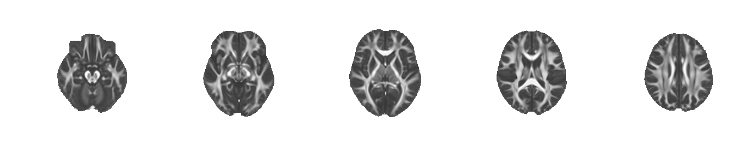

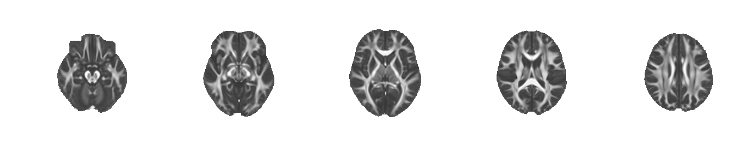

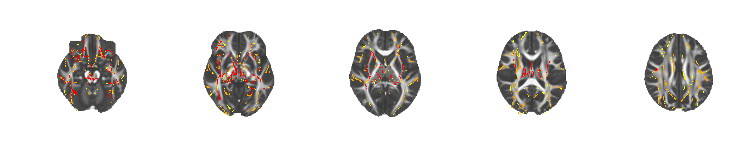

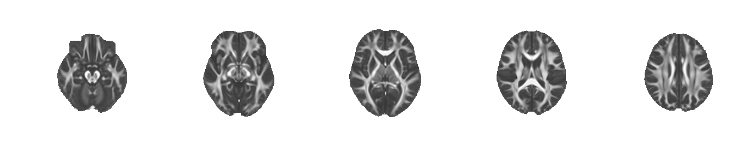

In [124]:
bg = nib.load('/imaging/jb07/CALM/CALM_FA_template.nii.gz').get_data()

for outcome in ['Reading', 'Maths']:
    for contrast in ['1', '2']:
        tbss_folder = '/imaging/jb07/CALM/LearningConnectome/Continuous_' + outcome + '/'
        data = nib.load(tbss_folder + '/stats/' + outcome + '_continuous_tfce_corrp_tstat' + contrast + '.nii.gz').get_data()
        data[data < 0.8] = 0
        data = np.ma.masked_where(data == 0, data)

        bg = np.ma.masked_where(bg == 0, bg)

        fig = plt.figure(figsize=(190*mm2inches, 50*mm2inches), dpi=600, tight_layout=True)
        subplot = 0

        for current_slice in [60,70,80,90,100]:
            plt.subplot(1,5,subplot+1)
            bg_img = plt.imshow(np.flipud(bg[..., current_slice].transpose()), cmap='Greys_r', figure=fig, alpha=0.8)
            stat_img = plt.imshow(np.flipud(data[..., current_slice].transpose()), 
                                  interpolation='none',
                                  cmap=cmap, 
                                  norm=norm,
                                  figure=fig)
            plt.axis('off')
            subplot += 1
        plt.savefig('./figures/' + outcome + '_continuous' + contrast + '.png', dpi=600)

Counting voxels

In [132]:
mask_file = '/imaging/jb07/CALM/LearningConnectome/Continuous_Maths/stats/Maths_continuous_tfce_corrp_tstat1.nii.gz'
sign_mask = nib.load(mask_file).get_data()
no_sign_voxels = len(sign_mask[np.where(sign_mask > 0.95)])

skeleton_file = '/imaging/jb07/CALM/LearningConnectome/Continuous_Maths/stats/mean_FA_skeleton_mask.nii.gz'
skeleton_mask = nib.load(skeleton_file).get_data()
skeleton_voxels = len(skeleton_mask[np.where(skeleton_mask == 1)])

## Comparison between learning outcomes and Conners-3 scores

In [ ]:
measures = ['ID No.',
            'Age_in_months',
            'WIAT_Numerical_raw',
            'WIAT_Reading_Raw',
            'Conners_inattention_raw',
            'Conners_hyperactivity_impulsivity_raw',
            'Conners_learning_problems_raw',
            'Conners_ExecutiveFunction_raw', 
            'Conners_agression_raw',
            'Conners_PeerRelations_raw']

df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/CALM_behavioural_data_Apr17.csv')[measures]
df.columns = ['ID',
              'Age',
              'Maths',
              'Reading',
              'ConnersInattention',
              'ConnersHyper',
              'ConnersLearning', 
              'ConnersExecutive',
              'ConnersAggression',
              'ConnersPeers']

df = df.dropna()
df['MRI.ID'] = [get_imaging_ID(str(int(ID)), './data/MRI_ID_match_Aug17.csv') for ID in df['ID'].values]
df = df.set_index('MRI.ID')

included_df = pd.read_csv('./data/GraphTheory_results.csv')
motion_df = pd.read_csv('./data/CALM_movement.csv')
motion_df.columns = ['MRI.ID', 'motion', 'volumes']
motion_df = motion_df.set_index('MRI.ID')

ICV_df = pd.read_csv('/imaging/jb07/CALM/T1/ICV.csv')
ICV_df = ICV_df.set_index('MRI.ID')

combined_df = pd.merge(df, motion_df, left_index=True, right_index=True)
combined_df = pd.merge(combined_df, ICV_df, left_index=True, right_index=True)
combined_df = combined_df.sort_index()
combined_df = combined_df[combined_df.index.isin(included_df['MRI.ID'])]

In [269]:
conners_measures = [measure for measure in combined_df.columns if re.search('Conners', measure)]

In [287]:
from scipy.stats import pearsonr

In [305]:
outcomes = ['Reading', 'Maths']

for outcome in outcomes:
    correlation_results = []
    for measure in conners_measures:
        r,p = spearmanr(combined_df[measure], combined_df[outcome])
        correlation_results.append([r, p])
        
    correlation_results = pd.DataFrame(correlation_results, columns=['R', 'p'])
    _,correlation_results['p'],_,_ = multipletests(correlation_results['p'].values, method='Bonferroni')
    correlation_results['R'] = correlation_results['R'].round(2)
    correlation_results['p'] = correlation_results['p'].round(3)
    correlation_results.index = conners_measures
    print(correlation_results)

                       R      p
ConnersInattention -0.12  1.000
ConnersHyper       -0.10  1.000
ConnersLearning    -0.53  0.000
ConnersExecutive    0.01  1.000
ConnersAggression  -0.06  1.000
ConnersPeers        0.15  0.438
                       R      p
ConnersInattention -0.18  0.192
ConnersHyper       -0.09  1.000
ConnersLearning    -0.39  0.000
ConnersExecutive   -0.09  1.000
ConnersAggression  -0.02  1.000
ConnersPeers        0.05  1.000


## Frequency of diagnoses

In [79]:
measures = ['ID No.',
            'ADD', 
            'ADHD', 
            'Dyslexia', 
            'Dyspraxia', 
            'Dysgraphia', 
            'Dyscalculia', 
            'FASD', 
            'Generalised_dev_delay', 
            'Global_delay', 
            'Social_anxiety_disorder', 
            'Depression', 
            'Autism', 
            'PDA', 
            'Tourettes', 
            'DAMP', 
            'Anxiety', 
            'OCD', 
            'Sensory_Processing_Disorder']

df = pd.read_csv('/imaging/jb07/CALM/Behavioural/Community_Detection/CALM_behavioural_data_Apr17.csv')[measures]
df.columns = np.hstack([['ID'], df.columns[1:]])

df = df.dropna()
df['MRI.ID'] = [get_imaging_ID(str(int(ID)), './data/MRI_ID_match_Aug17.csv') for ID in df['ID'].values]
df = df.set_index('MRI.ID')

graph_df = pd.read_csv('./data/GraphTheory_results.csv')
graph_df = graph_df.set_index('MRI.ID')

combined_df = pd.merge(df, graph_df, left_index=True, right_index=True)
combined_df = combined_df.sort_index()

In [81]:
combined_df = combined_df.iloc[0:133, :]

In [82]:
total = combined_df.shape[0]
ADD_ADHD = float(np.sum(np.sum(combined_df[['ADD', 'ADHD']])))
Dyslexia = float(np.sum(np.sum(combined_df['Dyslexia'])))
ASD = float(np.sum(np.sum(combined_df['Autism'])))
other = float(np.sum(np.sum(combined_df[df.columns[~df.columns.isin(['ID', 'ADD', 'ADHD', 'Dyslexia', 'Autism'])]])))
total_diag = float(np.sum(np.sum(combined_df[df.columns[1:]])))

In [83]:
print('Number of cases with ADD/ADHD diagnosis: %i (%i)' % (ADD_ADHD, 100*(ADD_ADHD/total)))
print('Number of cases with Dyslexia diagnosis: %i (%i)' % (Dyslexia, 100*(Dyslexia/total)))
print('Number of cases with ASD diagnosis: %i (%i)' % (ASD, 100*(ASD/total)))
print('Number of cases with other diagnoses: %i (%i)' % (other, 100*(other/total)))
print('Number of cases with a diagnosis: %i (%i)' % (total_diag, 100*(total_diag/total)))

Number of cases with ADD/ADHD diagnosis: 18 (13)
Number of cases with Dyslexia diagnosis: 12 (9)
Number of cases with ASD diagnosis: 5 (3)
Number of cases with other diagnoses: 7 (5)
Number of cases with a diagnosis: 42 (31)


In [85]:
combined_df.sum(axis=0)

ID_x                              29332.000000
ADD                                   2.000000
ADHD                                 16.000000
Dyslexia                             12.000000
Dyspraxia                             2.000000
Dysgraphia                            0.000000
Dyscalculia                           0.000000
FASD                                  0.000000
Generalised_dev_delay                 2.000000
Global_delay                          0.000000
Social_anxiety_disorder               0.000000
Depression                            0.000000
Autism                                5.000000
PDA                                   0.000000
Tourettes                             2.000000
DAMP                                  1.000000
Anxiety                               0.000000
OCD                                   0.000000
Sensory_Processing_Disorder           0.000000
clustering_coefficient              155.245095
degree                             4208.188235
density      